In [2]:
import wave
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
from os import listdir
from os.path import isfile, join
import librosa
import librosa.display
import tensorflow as tf
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D,BatchNormalization, Flatten
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

In [10]:
df_no_diagnosis = pd.read_csv('demographic_info.txt', names = 
                 ['Patient number', 'Age', 'Sex' , 'Adult BMI (kg/m2)', 'Child Weight (kg)' , 'Child Height (cm)'], delimiter = ' ')
diagnosis = pd.read_csv('patient_diagnosis.csv', names = ['Patient number', 'Diagnosis'])

In [3]:
root = 'C:/Users/home/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files'
filenames = [s.split('.')[0] for s in os.listdir(path = root) if '.txt' in s]

In [11]:
df =  df_no_diagnosis.join(diagnosis.set_index('Patient number'), on = 'Patient number', how = 'left')
df['Diagnosis'].value_counts()

Diagnosis
COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Pneumonia          6
Bronchiolitis      6
LRTI               2
Asthma             1
Name: count, dtype: int64

In [4]:
def Extract_Annotation_Data(file_name, root):
    tokens = file_name.split('_')
    recording_info = pd.DataFrame(data = [tokens], columns = ['Patient number', 'Recording index', 'Chest location','Acquisition mode','Recording equipment'])
    recording_annotations = pd.read_csv(os.path.join(root, file_name + '.txt'), names = ['Start', 'End', 'Crackles', 'Wheezes'], delimiter= '\t')
    return (recording_info, recording_annotations)

In [5]:
i_list = []
rec_annotations = []
rec_annotations_dict = {}
for s in filenames:
    (i,a) = Extract_Annotation_Data(s, root)
    i_list.append(i)
    rec_annotations.append(a)
    rec_annotations_dict[s] = a
recording_info = pd.concat(i_list, axis = 0)
recording_info.tail()

,Patient number,Recording index,Chest location,Acquisition mode,Recording equipment
0,224,1b2,Al,sc,Meditron
0,225,1b1,Pl,sc,Meditron
0,226,1b1,Al,sc,Meditron
0,226,1b1,Ll,sc,Meditron
0,226,1b1,Pl,sc,LittC2SE


In [6]:
no_label_list = []
crack_list = []
wheeze_list = []
both_sym_list = []
filename_list = []
for f in filenames:
    d = rec_annotations_dict[f]
    no_labels = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 0)].index)
    n_crackles = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 0)].index)
    n_wheezes = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 1)].index)
    both_sym = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 1)].index)
    no_label_list.append(no_labels)
    crack_list.append(n_crackles)
    wheeze_list.append(n_wheezes)
    both_sym_list.append(both_sym)
    filename_list.append(f)

In [7]:
file_label_df = pd.DataFrame(data = {'filename':filename_list})
file_label_df

,filename
0,101_1b1_Al_sc_Meditron
1,101_1b1_Pr_sc_Meditron
2,102_1b1_Ar_sc_Meditron
3,103_2b2_Ar_mc_LittC2SE
4,104_1b1_Al_sc_Litt3200
...,...
915,224_1b2_Al_sc_Meditron
916,225_1b1_Pl_sc_Meditron
917,226_1b1_Al_sc_Meditron
918,226_1b1_Ll_sc_Meditron


In [12]:
audio_path = 'C:/Users/home/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
diagnosis = []
patient_number = []
recording_index = []
chest_location = []
acquisition_mode = []
recording_equipment = []
sample_rate = []
duration = []

for i in tqdm(range(len(file_label_df['filename']))):
  info = file_label_df['filename'][i].split('_')
  patient_id, recording_idx, chest_loc, acq_mode, equipment = info

  diagnosis.append(df['Diagnosis'][int(patient_id) - 101])
  patient_number.append(patient_id)
  recording_index.append(recording_idx)
  chest_location.append(chest_loc)
  acquisition_mode.append(acq_mode)
  recording_equipment.append(equipment)

file_label_df['Diagnosis'] = diagnosis
file_label_df['Patient Number'] = patient_number
file_label_df['Chest Location'] = chest_location
file_label_df['Acquisition Mode'] = acquisition_mode
file_label_df['Recording Equipment'] = recording_equipment

  0%|          | 0/920 [00:00<?, ?it/s]

In [2]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np
import glob
import soundfile
from scipy.io.wavfile import read
import IPython.display as ipd

In [3]:
def preprocessing(audio_file, mode):
    # we want to resample audio to 16 kHz
    sr_new = 16000 # 16kHz sample rate
    x, sr = librosa.load(audio_file, sr=sr_new)
    if len(x.shape) > 1:
      x = librosa.to_mono(x)
    # padding sound 
    # because duration of sound is dominantly 20 s and all of sample rate is 22050
    # we want to pad or truncated sound which is below or above 20 s respectively
    max_len = 3 * sr_new  # length of sound array = time x sample rate
    if x.shape[0] < max_len:
      # padding with zero
      pad_width = max_len - x.shape[0]
      x = np.pad(x, (0, pad_width))
    elif x.shape[0] > max_len:
      # truncated
      x = x[:max_len]
    
    if mode == 'mfcc':
      feature = librosa.feature.mfcc(y=x, sr=sr_new)
    
    # elif mode == 'log_mel':
    #   feature = librosa.feature.melspectrogram(y=x, sr=sr_new, n_mels=128, fmax=8000)
    #   feature = librosa.power_to_db(feature, ref=np.max)
    

    return feature

In [21]:
labels = []
preprocessed_data = []
for i in tqdm(range(len(file_label_df['filename']))):
  if file_label_df['Diagnosis'][i] in ['Pneumonia', 'Healthy']:
    labels.append(file_label_df['Diagnosis'][i])
    audio_file = audio_path + file_label_df['filename'][i] + '.wav'
    data = preprocessing(audio_file, mode = 'mfcc')
    preprocessed_data.append(data)
preprocessed_data = np.array(preprocessed_data)
labels = np.array(labels)
preprocessed_data = preprocessed_data.reshape((-1, 20, 157, 1))
encoder = LabelEncoder()
i_labels = encoder.fit_transform(labels)
oh_labels = to_categorical(i_labels,num_classes=2) 
unique_values, counts = np.unique(oh_labels, return_counts=True)

# Display unique values and their counts
for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")

  0%|          | 0/920 [00:00<?, ?it/s]

In [9]:
num_rows = 15
num_columns = 157
num_channels = 1


num_labels = 2
filter_size = 2

def create_model(input_shape):
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=filter_size,input_shape=input_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dense(64, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Conv2D(filters=32, kernel_size=filter_size, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))

    model.add(Conv2D(filters=64, kernel_size=filter_size, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    # model.add(Dropout(0.5))

    model.add(GlobalAveragePooling2D())

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))

    model.add(Dense(num_labels, activation='softmax')) 
        
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

input_shape = (num_rows, num_columns, num_channels)  # Shape for CNN
model = create_model(input_shape)

# Construct model 


c:\Users\home\anaconda3\envs\dxcup\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
num_epochs = 100
num_batch_size = 64

callbacks = [
    ModelCheckpoint(
        filepath='kaggle_only_{epoch:02d}.keras',
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1)
]
start = datetime.now()

history = model.fit(preprocessed_data, oh_labels, batch_size=num_batch_size, epochs=num_epochs, callbacks=callbacks, verbose=1, validation_split=0.2)



duration = datetime.now() - start
print("Training completed in time: ", duration)

NameError: name 'preprocessed_data' is not defined

<Figure size 640x480 with 0 Axes>

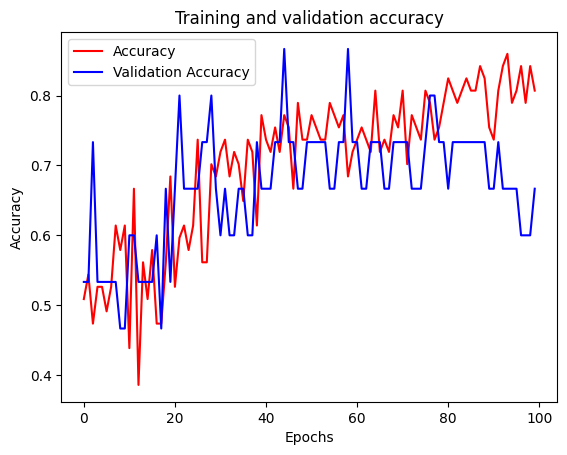

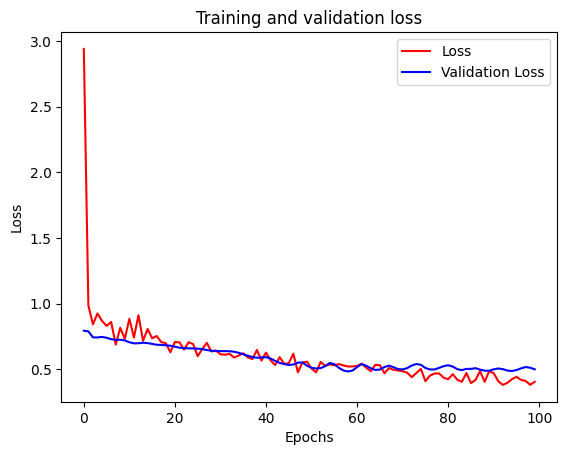

<Figure size 640x480 with 0 Axes>

In [89]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


In [ ]:
# from tensorflow.keras.models import load_model

# model = load_model('kaggle_only_45.keras')

In [ ]:
orig_labels = []
orig_preprocessed_data = []
folder_path = "../data/orig/healthy/audiowav"
# folder_path = "data/breath/0"
for filename in os.listdir(folder_path):
    orig_labels.append(0)
    data = preprocessing(os.path.join(folder_path, filename), mode = 'mfcc')
    orig_preprocessed_data.append(data)
folder_path = "../data/data"
# folder_path = "data/breath/1"

for filename in os.listdir(folder_path):
    orig_labels.append(1)
    data = preprocessing(os.path.join(folder_path, filename), mode = 'mfcc')
    orig_preprocessed_data.append(data)
orig_preprocessed_data = np.array(orig_preprocessed_data)
orig_labels = np.array(orig_labels)
encoder = LabelEncoder()
orig_labels = to_categorical(encoder.fit_transform(orig_labels),num_classes=2) 
unique_values, counts = np.unique(orig_labels, return_counts=True)
orig_preprocessed_data = orig_preprocessed_data.reshape((-1, 20, 94, 1))
# Display unique values and their counts
for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")

In [31]:
print("0: ", sum([lbl[0]==1 for lbl in orig_labels]))
print("1: ", sum([lbl[1]==1 for lbl in orig_labels]))

IndexError: invalid index to scalar variable.

In [ ]:
sum([lbl[0]==1 for lbl in orig_labels])

In [7]:
x_train, x_test, y_train, y_test = train_test_split(orig_preprocessed_data, orig_labels, test_size=0.2)

In [33]:
num_epochs = 30
num_batch_size = 8

callbacks = [
    ModelCheckpoint(
        filepath='mono_{epoch:02d}.keras',
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1)
]
start = datetime.now()

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_split=0.3, class_weight={0: 0.75, 1: 1.5})



duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9298 - loss: 0.2530 - val_accuracy: 0.5000 - val_loss: 0.9073
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8696 - loss: 0.3098 - val_accuracy: 0.6667 - val_loss: 0.7316
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8429 - loss: 0.3068 - val_accuracy: 0.5833 - val_loss: 0.8039
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9030 - loss: 0.2488 - val_accuracy: 0.5833 - val_loss: 0.9814
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8696 - loss: 0.2606 - val_accuracy: 0.8333 - val_loss: 0.5051
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8095 - loss: 0.3454 - val_accuracy: 0.5000 - val_loss: 0.9009
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9774 - loss: 0.1676 - val_accuracy: 0.5000 - val_loss: 0.9832
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 0.2152 - val_accuracy: 0.6667 - val_loss: 0.6676


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Accuracy: 0.91
F1 Score: 0.67
Precision: 1.00
Recall: 0.50


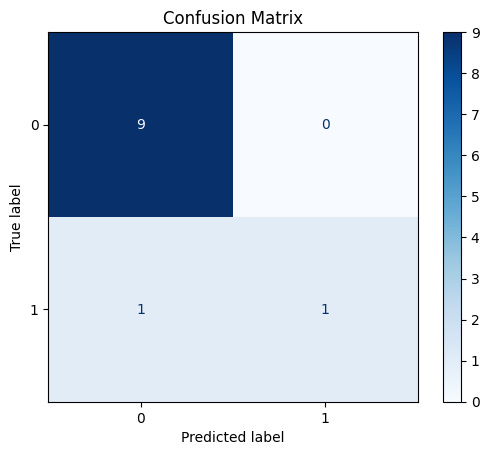

In [34]:
pred = model.predict(x_test)
pred_labels = pred.argmax(axis=1)  
true_labels = y_test.argmax(axis=1)  # Assuming test_labels is one-hot encoded

# Calculate the metrics
accuracy = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Display the confusion matrix
ConfusionMatrixDisplay(conf_matrix).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Accuracy: 0.88
F1 Score: 0.79
Precision: 1.00
Recall: 0.65


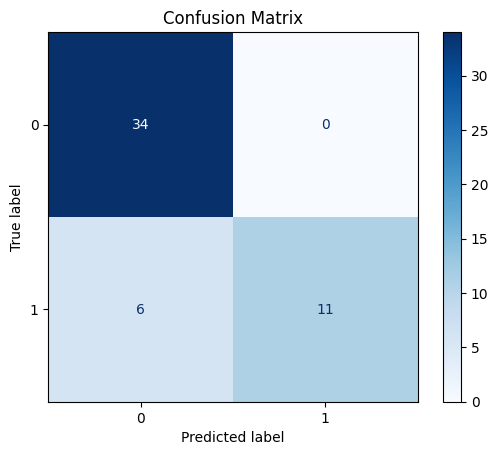

In [37]:
pred = model.predict(orig_preprocessed_data)
pred_labels = pred.argmax(axis=1)  
true_labels = orig_labels.argmax(axis=1)  # Assuming test_labels is one-hot encoded

# Calculate the metrics
accuracy = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Display the confusion matrix
ConfusionMatrixDisplay(conf_matrix).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

<Figure size 640x480 with 0 Axes>

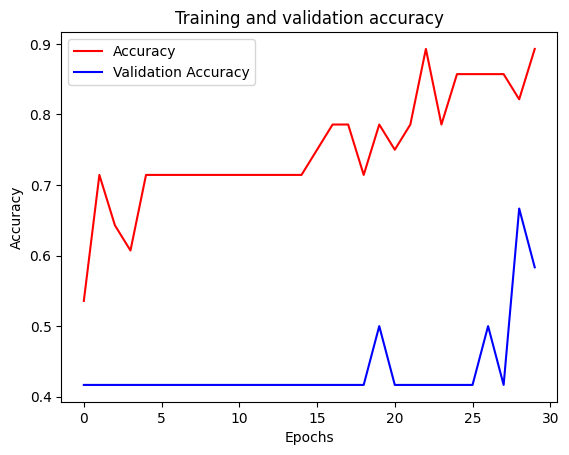

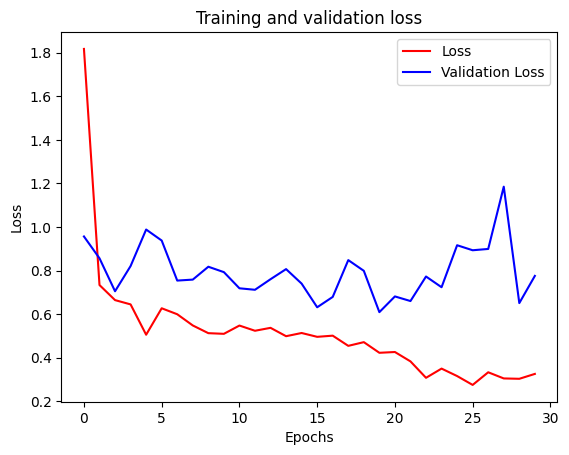

<Figure size 640x480 with 0 Axes>

In [13]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


In [36]:
model.save("cough_model.h5")


In [39]:
# test_data = preprocessing("../data\\orig\\healthy\\audiowav\\audio27.wav", mode = 'mfcc')
test_data = preprocessing("../data\\data\\New Recording 11 [cough only].wav", mode = 'mfcc')
test_data = test_data.reshape((-1, 20, 94, 1))
pred = model.predict(test_data)
print(round(pred[0][0], 3), round(pred[0][1], 3))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
0.002 0.998


In [20]:
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model("my_model.h5")

# Convert the model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open("my_model.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\home\AppData\Local\Temp\tmp1xxm31mu\assets


INFO:tensorflow:Assets written to: C:\Users\home\AppData\Local\Temp\tmp1xxm31mu\assets


Saved artifact at 'C:\Users\home\AppData\Local\Temp\tmp1xxm31mu'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 20, 157, 1), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  2090480790672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2090480784144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2090604816784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2090604819088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2090604814288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2090604815632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2090604819664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2090604816976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2090604817552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2090604815056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  209060

In [32]:
orig_labels = []
orig_preprocessed_data = []
folder_path = "../data/orig/healthy/audiowav"
# folder_path = "data/breath/0"
for filename in os.listdir(folder_path):
    # if(filename.endswith(".")):

    orig_labels.append(0)
    data = preprocessing(os.path.join(folder_path, filename), mode = 'mfcc')
    orig_preprocessed_data.append(data)
folder_path = "../data/data"
# folder_path = "data/breath/1"

for filename in os.listdir(folder_path):
    if filename.endswith("[cough only].wav"):
        orig_labels.append(1)
        data = preprocessing(os.path.join(folder_path, filename), mode = 'mfcc')
        orig_preprocessed_data.append(data)
orig_preprocessed_data = np.array(orig_preprocessed_data)
orig_labels = np.array(orig_labels)
encoder = LabelEncoder()
orig_labels = to_categorical(encoder.fit_transform(orig_labels),num_classes=2) 
unique_values, counts = np.unique(orig_labels, return_counts=True)
orig_preprocessed_data = orig_preprocessed_data.reshape((-1, 20, 94, 1))
# Display unique values and their counts
for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")

Value: 0.0, Count: 51
Value: 1.0, Count: 51
